# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images

## Investigating the dataset

As dataset we use the StandordCars Dataset, which consists of around 8000 images in the train set. Let's see if this is enough to get good results ;-)

# Building the Diffusion Model



In [182]:
import torch, torchvision, matplotlib.pyplot as plt, numpy as np
from datasets import load_dataset
import torch.nn.functional as F


train = load_dataset("tanganke/stanford_cars", split="train")   # ~8,144 imgs
test  = load_dataset("tanganke/stanford_cars", split="test")    # ~8,041 imgs


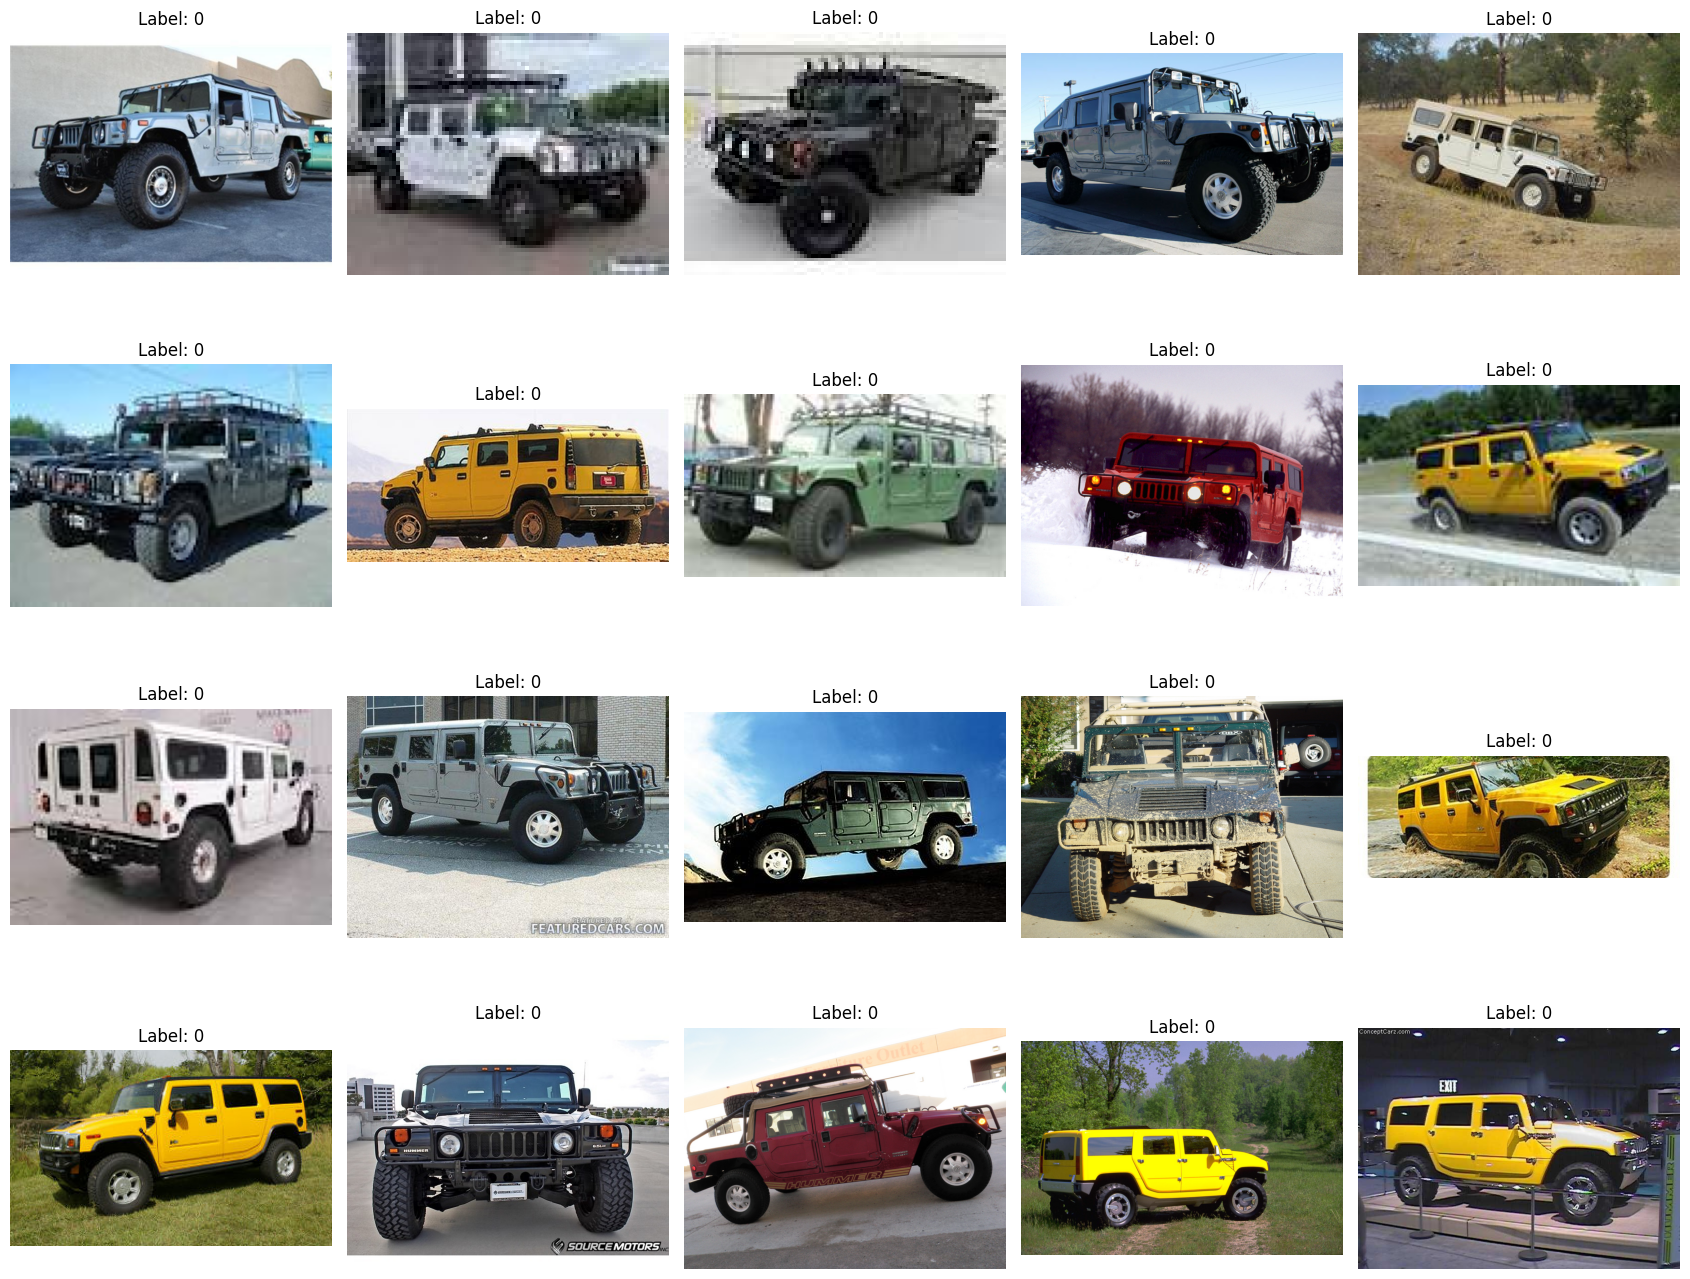

In [183]:
import matplotlib.pyplot as plt

def show_images(ds, n_samples=20, cols=5):
    plt.figure(figsize=(17, 17))
    for i, sample in enumerate(ds):
        if i == n_samples:
            break
        plt.subplot((n_samples // cols) + 1, cols, i + 1)
        plt.imshow(sample["image"])
        plt.title(f'Label: {sample["label"]}')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(train)


# Building the Diffusion Model

---




## Step 1: The forward process = Noise scheduler


We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

In [184]:
# ======== 1. Define linear beta schedule =
# This creates a linearly increasing noise schedule (βₜ)
# from 'start' to 'end' over all diffusion timesteps.
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

In [185]:

# ======== 2. Helper: get a value from a list at specific time step
# Given a tensor of values (like βₜ or αₜ), and a batch of time indices t,
# this picks the correct value for each sample in the batch.
def get_index_from_list(vals, t, x_shape):
      batch_size = t.shape[0]
      out = vals.gather(-1, t.cpu())
      return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [186]:
# ======== 3. Forward diffusion (add noise)
# Adds noise to an input image x₀ based on the chosen time step t.
# This simulates the forward diffusion process q(xₜ | x₀).
def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # Return the noisy image: sqrt(ᾱₜ) * x₀ + sqrt(1-ᾱₜ) * noise
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
         + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [187]:
# ======== 4. Precompute constants for the diffusion process ========

In [188]:
T = 300
betas = linear_beta_schedule(timesteps=T)  # noise schedule (βₜ)

# αₜ = 1 - βₜ  → how much of the original signal remains each step
alphas = 1. - betas

# ᾱₜ = cumulative product of all αₜ up to step t
alphas_cumprod = torch.cumprod(alphas, axis=0)

# ᾱₜ₋₁ (previous cumulative product)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# Useful precomputed terms for faster sampling
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # 1 / √αₜ
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # √ᾱₜ
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)  # √(1 - ᾱₜ)

# Posterior variance for reverse process (used later)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## lets test **it**

In [189]:
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

# ----------------------------
# 1) Config
# ----------------------------
IMG_SIZE   = 256
BATCH_SIZE = 128
T          = 300  # diffusion steps


In [190]:
def ensure_pil_rgb(im):

    if isinstance(im, list):
        if len(im) != 1:
            raise TypeError(f"Expected single image, got list len={len(im)}")
        im = im[0]
    if isinstance(im, Image.Image):
        return im.convert("RGB")
    if torch.is_tensor(im):
        return to_pil_image(im.detach().cpu().squeeze()).convert("RGB")
    arr = np.array(im) if not isinstance(im, np.ndarray) else im
    arr = np.squeeze(arr)
    if arr.ndim == 3 and arr.shape[0] in (1,3,4) and arr.shape[-1] not in (1,3,4):
        arr = np.transpose(arr, (1,2,0))   # CHW -> HWC
    if arr.ndim == 2:                      #  HxW -> 3 c
        arr = np.stack([arr, arr, arr], axis=-1)
    return Image.fromarray(arr).convert("RGB")

data_transform = transforms.Compose([
    transforms.Lambda(ensure_pil_rgb),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                 # -> [0,1]
    transforms.Lambda(lambda t: t*2 - 1),  # -> [-1,1]
])


In [191]:
def apply_transform(examples):

    imgs = examples["image"]
    if isinstance(imgs, list):
        examples["pixel_values"] = [data_transform(ensure_pil_rgb(im)) for im in imgs]
    else:
        examples["pixel_values"] = data_transform(ensure_pil_rgb(imgs))
    return examples


data_hf = concatenate_datasets([train, test])
data_t  = data_hf.with_transform(apply_transform)

def collate_fn(batch):
    xs = torch.stack([b["pixel_values"] for b in batch])            # [B,3,H,W]
    ys = torch.tensor([int(b["label"]) for b in batch], dtype=torch.long)
    return xs, ys

dataloader = DataLoader(
    data_t,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=0,
    persistent_workers=False,
)

# check
xb, yb = next(iter(dataloader))
print("Batch ok:", xb.shape, xb.min().item(), xb.max().item())  # [B,3,IMG,IMG], ~[-1,1]



Batch ok: torch.Size([128, 3, 256, 256]) -1.0 1.0


In [192]:
# ----------------------------
# Reverse/denorm + viewers  (ADD THIS)
# ----------------------------

def tensor_to_numpy_0_1(x):
    """x in [-1,1], [C,H,W] or [1,C,H,W] -> NumPy HWC in [0,1]."""
    if x.ndim == 4: x = x[0]
    x = x.detach().cpu().clamp(-1, 1)
    if x.ndim == 2: x = x.unsqueeze(0)
    if x.shape[0] == 1: x = x.repeat(3, 1, 1)  # gray -> fake RGB
    x = (x + 1) / 2.0
    return x.permute(1, 2, 0).numpy()

def tensor_to_pil(x):
    arr01 = tensor_to_numpy_0_1(x)
    return Image.fromarray((arr01 * 255).astype(np.uint8))

def show_tensor_image(x, title=None):
    plt.imshow(tensor_to_numpy_0_1(x))
    if title: plt.title(title)
    plt.axis('off')


In [193]:
from torchvision.utils import make_grid

def show_tensor_batch(xb, n=25, cols=5, title=None):
    xb = xb[:n].detach().cpu().clamp(-1, 1)
    grid = make_grid((xb + 1)/2, nrow=cols)      # -> [C,H,W] in [0,1]
    grid = grid.permute(1, 2, 0).numpy()         # -> HWC
    plt.figure(figsize=(2.2*cols, 2.2*((n+cols-1)//cols)))
    if title: plt.title(title)
    plt.imshow(grid); plt.axis('off'); plt.tight_layout(); plt.show()

Batch shape: torch.Size([128, 3, 256, 256]) range: (-1.0, 1.0)


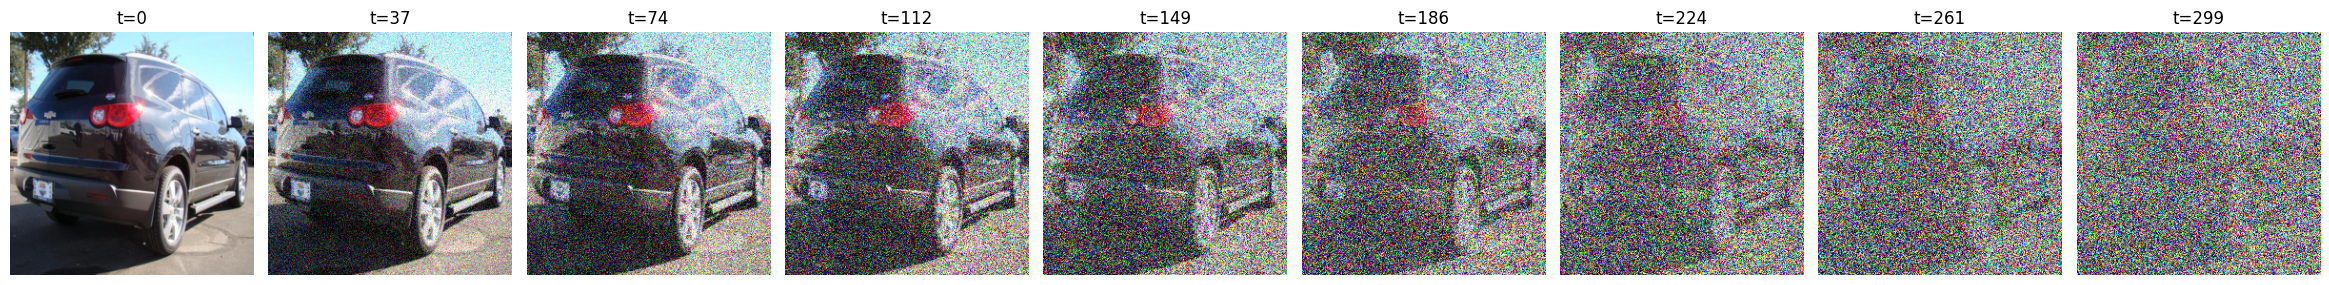

In [194]:
# Example usage with your loop:
xb, yb = next(iter(dataloader))
print("Batch shape:", xb.shape, "range:", (xb.min().item(), xb.max().item()))

num_images = 9
steps = torch.linspace(0, T-1, steps=num_images, dtype=torch.long)

x0 = xb[:1].to(device)
plt.figure(figsize=(2.6*num_images, 3))
for i, idx in enumerate(steps.tolist(), 1):
    t = torch.tensor([idx], dtype=torch.long, device=device)
    x_t, _ = forward_diffusion_sample(x0, t, device=device)
    plt.subplot(1, num_images, i); plt.title(f"t={int(idx)}")
    show_tensor_image(x_t)
plt.tight_layout(); plt.show()
